#영화 추천 데이터셋을 학습하여 최적 추천시스템 개발

데이터셋이란
1. 1998년, 1000명의 유저가 1700개의 영화에 대해 등급을 적용
2. 총 평가 데이터 개수 대략 100만개
3. Train, Test 구분이 없음

해결방안
1. 데이터 분석
2. 알고리즘 선택 -> 신경망(컨텐츠X, 협업△)
3. Training 이후 Test set에 대하여 검증
___
### 데이터 분석

1. u.user : 1000명의 인적사항 : (id, 나이, 성별, 직업, 개인코드)

2. u.data : 1000명의 user의 1700개의 영화 평 : (u_id, m_id, 순위)

3. u.item : 1700개의 영화 정보 : (m_id, 이름, 장르)


### 알고리즘

1. user embedding : 

   User_id 정보 취합 : 500개의 개별 user

   User_id 64차원 embedding화 : user_emb = nn.Emdebbing(500,64)
2. item embedding :   

   item 정보 취합 : 1700개 개별 movie

   item 64차원 embedding화 : item_emb = nn.Embedding(1700,64)
3. [User,Item] concatenate

   사용예시 : Con = torch.cat((user_emb.item_emb),dim=1)

   해석 : Tensor 2번째 랭크(dim=1)자리 user_emb[batch,64], item_emb[batch,64] 합치기[batch,128]

   -> 두 행렬을 그냥 옆으로 이어붙여서 신경망에 곱을 취하려고 함

   텐서 결과 = [batch,2*64]
4. Fully connected layer

   [batch,2*64] -> [batch,1] (sigmoid, 0~1)

   Regulariztion restoration(정규화 복원)

   -> result*(max_rating - min_rating) + min_rating  : 1~5
5. Optimization

        loss = criterion(y_infer,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

@신경망 Embedding은 추천시스템에서의 Embedding과는 다름 : 카테고리형 변수(MNIST숫자)를 고차원의 공간으로 변환

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split #train data와 test data를 분류
from sklearn.preprocessing import LabelEncoder 
# 문자를 음이 아닌 정수형으로 바꿔줌(반대로 라벨코드로 원본값을 구할 수 있음)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Download movielens data

In [5]:
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip",'movielens.zip')
zip_ref = zipfile.ZipFile('movielens.zip','r')
zip_ref.extractall()
print('Done. Dataset contains')
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains
b'943 users\n1682 items\n100000 ratings\n'


In [10]:
user_cols = ['user_id','age','sex','occupation','zip_code']
users = pd.read_csv('ml-100k/u.user',sep='|',names=user_cols,encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [11]:
#사용자의 아이템에 대한 평가
rating_cols = ['user_id','movie_id','rating','unix_timestemp']
ratings = pd.read_csv('ml-100k/u.data',sep='\t',names=rating_cols,encoding='latin-1')
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestemp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movie_cols = ['movie_id','title','release_date','video_release_data','imdb_url']+genre_cols
movies = pd.read_csv('ml-100k/u.item',sep='|',names=movie_cols,encoding='latin-1')
movies = movies.drop(columns=['video_release_data','imdb_url'])
movies.head()

,movie_id,title,release_date,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [14]:
#scikit learn - one_hot encoding 같은 부분 이용하기 위한 tool : Label Encoding
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

#정규화 하기위한 정보, 정규화 복원
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users,n_movies,min_rating,max_rating

(943, 1682, 1.0, 5.0)

In [16]:
movies['title'][64] # 영화 타이틀 순서대로 했을 때 64번째

"What's Eating Gilbert Grape (1993)"

In [23]:
X = ratings[['user','movie']].values
Y = ratings['rating'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2) #20%를 테스트용으로 씀

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(X_train[0])

X_train_array = [X_train[:,0],X_train[:,1]]
X_test_array = [X_test[:,0],X_test[:,1]]

(80000, 2) (20000, 2) (80000,) (20000,)
[535 270]


#dataset

In [24]:
class dataset(torch.utils.data.Dataset):
  def __init__(self,x,y):
    self.x = torch.LongTensor(x)
    self.y = torch.Tensor(y)

  def __getitem__(self,idx):
    return self.x[idx], self.y[idx] 

  def __len__(self):
    return len(self.x)

In [25]:
train_dataset = dataset(X_train_array,Y_train)
test_dataset = dataset(X_test_array,Y_test)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False,drop_last=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


#Making recommender system model

In [27]:
n_factors = 64 #64차원으로 바꿈
class Recommender_model(nn.Module):
    def __init__(self):
        super(Recommender_model,self).__init__()
        self.emb1 = nn.Embedding(n_users,n_factors)
        self.emb2 = nn.Embedding(n_movies,n_factors)
        self.lin1 = nn.Linear(2*n_factors,1) # 128*1 weight matrix

    def forward(self,x):
        user,item = x[:,0].view(-1,1), x[:,1].view(-1,1)

        user = self.emb1(user)
        user = user.view(-1,n_factors)

        item = self.emb2(item)
        item = item.view(-1,n_factors)

        con = torch.cat([user,item],dim=-1) # user, item을 붙임
        value = F.sigmoid(self.lin1(con)) #정규화

        value = value * (max_rating - min_rating) + min_rating # 정규화 복원 1~5
        return value

In [35]:
model = Recommender_model().to(device)
opt = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-15)

criterion = nn.MSELoss() # mean((y-y^)**2)

train_loss_trend,test_loss_trend = [],[]
for ep in range(300):
  avg_loss = 0
  #training
  for x,y in train_loader:
    x = x.to(device)
    y = y.to(device)
    y_infer = model(x)
    loss = criterion(y_infer,y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    avg_loss += loss.item()
  train_loss_trend.append(avg_loss/len(train_loader))

  if ep % 10 == 0:
    print('Epoch : {:d}, train loss : {:f}'.format(ep,avg_loss/len(train_loader)))
    #test
  avg_loss = 0 
  for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    y_infer = model(x)
    loss = criterion(y_infer,y)
    avg_loss += loss.item()
  test_loss_trend.append(avg_loss/len(test_loader))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0, train loss : 1.006060
Epoch : 10, train loss : 0.258482
Epoch : 20, train loss : 0.299044
Epoch : 30, train loss : 0.257855
Epoch : 40, train loss : 0.255072
Epoch : 50, train loss : 0.250855
Epoch : 60, train loss : 0.250895
Epoch : 70, train loss : 0.250017
Epoch : 80, train loss : 0.250139
Epoch : 90, train loss : 0.250010
Epoch : 100, train loss : 0.250007
Epoch : 110, train loss : 0.250006
Epoch : 120, train loss : 0.250000
Epoch : 130, train loss : 0.250000
Epoch : 140, train loss : 0.250000
Epoch : 150, train loss : 0.250000
Epoch : 160, train loss : 0.250000
Epoch : 170, train loss : 0.250000
Epoch : 180, train loss : 0.250000
Epoch : 190, train loss : 0.250000
Epoch : 200, train loss : 0.250000
Epoch : 210, train loss : 0.250000
Epoch : 220, train loss : 0.250000
Epoch : 230, train loss : 0.250000
Epoch : 240, train loss : 0.250000
Epoch : 250, train loss : 0.250000
Epoch : 260, train loss : 0.250000
Epoch : 270, train loss : 0.250000
Epoch : 280, train loss : 0.250

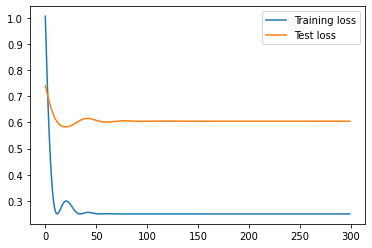

In [38]:
plt.plot(train_loss_trend,label='Training loss')
plt.plot(test_loss_trend,label='Test loss')
plt.legend()

In [40]:
# 미션 check
user_number =23 # 여러분이 원하는 user_id를 입력해보세요
user,movie = X_test[user_number][0],X_test[user_number][1]
favor = Y_test[user_number]
inference = model(torch.LongTensor(X_test[user_number].reshape(-1,2)).to(device)).detach().cpu().numpy().squeeze()
print('유저번호',user)
print('영화제목',movies['title'][movie])
print('실제 선호도',favor)
print('예측 선호도',inference)
print('Distance {}'.format((favor-inference)**2))

유저번호 292
영화제목 Fierce Creatures (1997)
실제 선호도 2.0
예측 선호도 2.9354446
Distance 0.875056587376605


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
